# Coursework 1: Geo-Localization

In [1]:
import json
from collections import Counter
from tqdm import tqdm
import math
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap, Normalize
import seaborn as sns
import numpy as np
import spacy
import pandas as pd

In [2]:
with open('datajson/geoLondonSep2022_1.json', 'r', encoding='utf8') as file:
    data = json.load(file)

with open('datajson/geoLondonSep2022_2.json', 'r', encoding='utf8') as file:
    data2 = json.load(file)

with open('datajson/geoLondonSep2022_3.json', 'r', encoding='utf8') as file:
    data3 = json.load(file)

with open('datajson/geoLondonSep2022_4.json', 'r', encoding='utf8') as file:
    data4 = json.load(file)

with open('datajson/geoLondonSep2022_5.json', 'r', encoding='utf8') as file:
    data5 = json.load(file)

In [3]:
# Combining all the data files
final_data = data + data2 + data3 + data4 + data5

In [4]:
class GridCreator:
    def __init__(self, coords):
        self.coords = coords

    # Method to calculate the haversine distance between two points
    def computeDistance(self, lat1, lon1, lat2, lon2):
        R = 6373.0
    
        phi1 = lat1 * (math.pi / 180)
        phi2 = lat2 * (math.pi / 180)
    
        delta1 = (lat2 - lat1) * (math.pi / 180)
        delta2 = (lon2 - lon1) * (math.pi / 180)
    
        a = math.sin(delta1 / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta2 / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        d = R * c
        return d
    

    # Method to create grids for the given coordinates using the haversine distance formula
    def createGrid(self):
    
        self.rows = int(np.ceil(self.computeDistance(self.coords[1], self.coords[0], self.coords[1], self.coords[2])))
        self.columns = int(np.ceil(self.computeDistance(self.coords[3], self.coords[0], self.coords[1], self.coords[0])))
        self.noofGrids = int(self.rows * self.columns)
    
        print('Number of rows is: ', self.rows)
        print('Number of columns is: ', self.columns)
        print('Number of grids is: ', self.noofGrids)
    
        self.rowPoints = []
        self.colPoints = []
        self.lonOffset = (self.coords[2] - self.coords[0]) / self.columns
        self.latOffset = (self.coords[3] - self.coords[1]) / self.rows
    
        for i in range(self.rows):
            self.rowPoints.append(self.coords[1] + i * self.latOffset)
        for j in range(self.columns):
            self.colPoints.append(self.coords[0] + j * self.lonOffset)
        
        print(self.rowPoints)
        print(self.colPoints)

In [5]:
# Creation of the data grid of 1 km2
bounding_coords = [-0.563, 51.261318, 0.28036, 51.686031]
grid_creator = GridCreator(bounding_coords)
grid_creator.createGrid()

Number of rows is:  59
Number of columns is:  48
Number of grids is:  2832
[51.261318, 51.268516525423735, 51.27571505084746, 51.28291357627119, 51.290112101694916, 51.29731062711865, 51.30450915254237, 51.311707677966105, 51.31890620338983, 51.32610472881356, 51.33330325423729, 51.34050177966102, 51.34770030508475, 51.354898830508475, 51.36209735593221, 51.36929588135593, 51.37649440677966, 51.383692932203395, 51.39089145762712, 51.39808998305085, 51.40528850847458, 51.41248703389831, 51.41968555932203, 51.426884084745765, 51.43408261016949, 51.44128113559322, 51.448479661016954, 51.45567818644068, 51.46287671186441, 51.470075237288135, 51.47727376271187, 51.48447228813559, 51.491670813559324, 51.49886933898305, 51.50606786440678, 51.51326638983051, 51.52046491525424, 51.52766344067797, 51.534861966101694, 51.542060491525426, 51.54925901694915, 51.55645754237288, 51.56365606779661, 51.57085459322034, 51.57805311864407, 51.585251644067796, 51.59245016949153, 51.59964869491525, 51.60684

In [6]:
locations = np.zeros([grid_creator.rows, grid_creator.columns])
rowPoints = grid_creator.rowPoints
colPoints = grid_creator.colPoints

# Looping through all the tweet data and assigning a count for tweet which falls under each grid to populate the data
for tweet in tqdm(final_data, desc = "Processing Tweets", unit = "tweets"):
    tweet_id = tweet['_id']
    tweet_lon = tweet['coordinates'][0]
    tweet_lat = tweet['coordinates'][1]
    
    np_lat = np.empty([grid_creator.rows])
    np_lon = np.empty([grid_creator.columns])

    lat_index = 0
    lon_index = 0

    for i in range(len(rowPoints)):
        if rowPoints[i] >= tweet_lat:
            lat_index = i-1
            break
    for i in range(len(colPoints)):
        if colPoints[i] >= tweet_lon:
            lon_index = i-1
            break

    locations[lat_index, lon_index] += 1
            

Processing Tweets: 100%|█████████████████████████████████████████████████| 13192/13192 [00:00<00:00, 141104.37tweets/s]


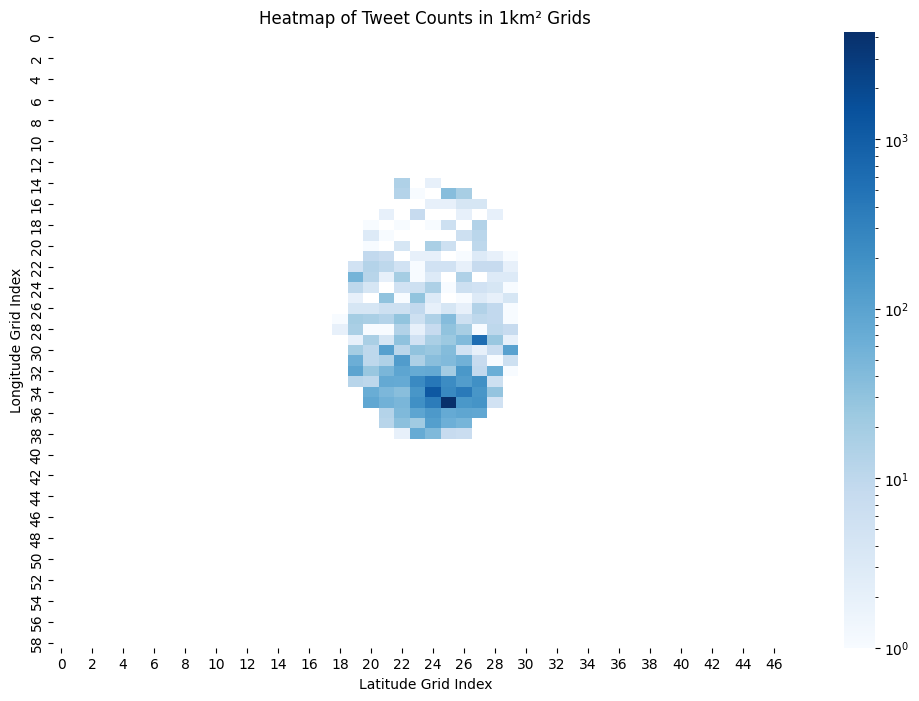

In [7]:
# Plotting the heatmap of the tweet counts in the 1km² grids
plt.figure(figsize=(12, 8))
sns.heatmap(locations, cmap='Blues', norm=LogNorm(vmin=1, vmax=np.max(locations)), xticklabels=2)
plt.title('Heatmap of Tweet Counts in 1km² Grids')
plt.xlabel('Latitude Grid Index')
plt.ylabel('Longitude Grid Index')
plt.show()

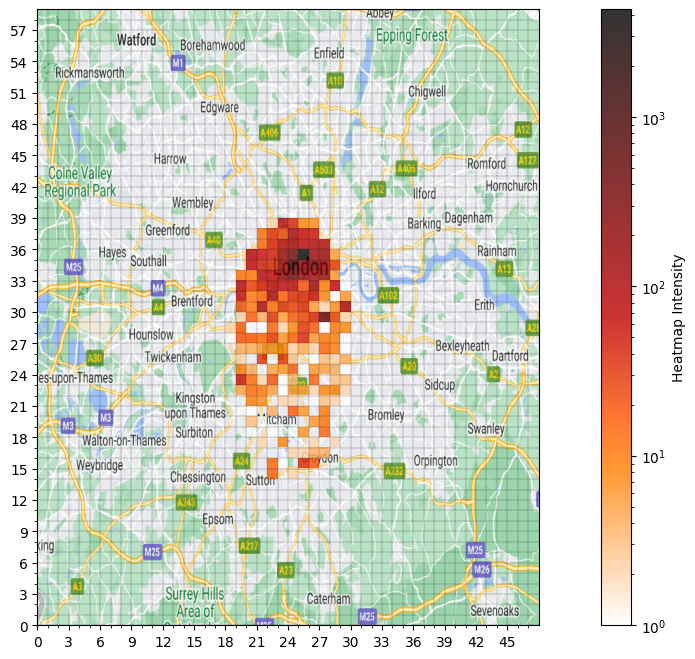

In [8]:
# Plotting the heatmap on the map of London with corrected data
geo_corrected_loc = locations[::-1, :]
rows, cols = len(rowPoints), len(colPoints)

map_image = plt.imread('london_city.png')

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(map_image, extent=[0, cols, 0, rows])


xticks = np.arange(0, cols, 3)
yticks = np.arange(0, rows, 3)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticks(np.arange(0, cols, 1), minor=True)
ax.set_yticks(np.arange(rows-1, -1, -1), minor=True)
ax.grid(which='both', color='black', linestyle='--', linewidth=0.2)

cmap = plt.get_cmap('gist_heat_r')
heatmap = ax.imshow(geo_corrected_loc, cmap=cmap, norm=LogNorm(), alpha=0.8, interpolation='none', extent=[0, cols, 0, rows])


cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', pad=0.08)
cbar.set_label('Heatmap Intensity')

plt.show()


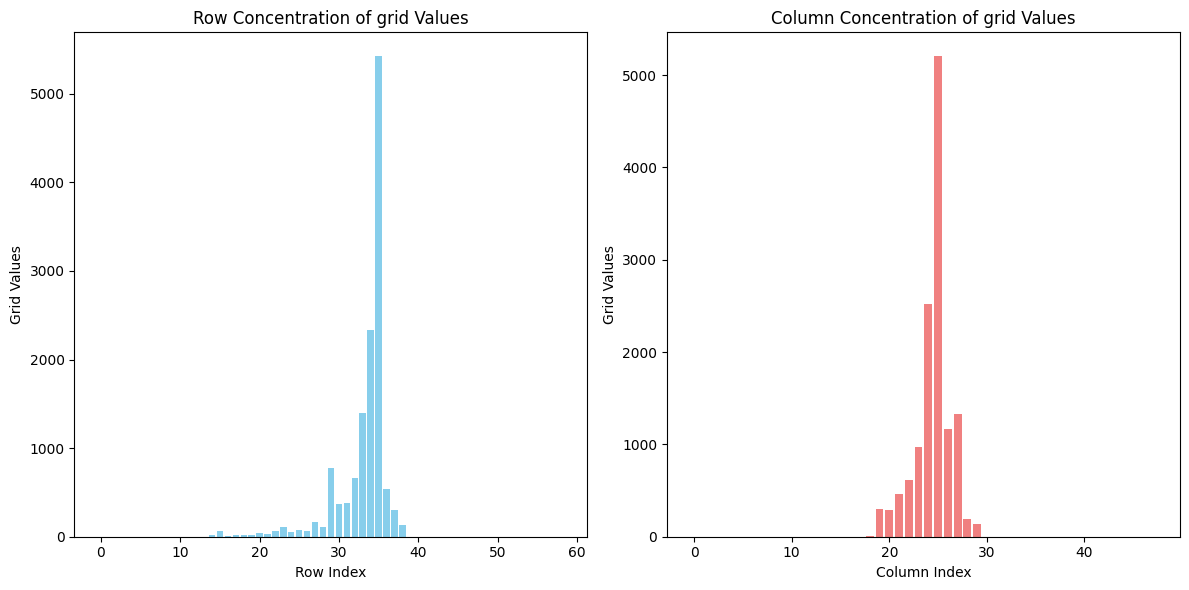

In [9]:
# Plotting the concentration of the grid values along rows and columns (latitude and longitude)
df = pd.DataFrame(locations)

row_concentration = df[df > 0].sum(axis=1)  # Concentration along rows
col_concentration = df[df > 0].sum(axis=0)  # Concentration along columns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(row_concentration.index, row_concentration.values, color='skyblue')
plt.title('Row Concentration of grid Values')
plt.xlabel('Row Index')
plt.ylabel('Grid Values')

# Plotting Column Concentration
plt.subplot(1, 2, 2)
plt.bar(col_concentration.index, col_concentration.values, color='lightcoral')
plt.title('Column Concentration of grid Values')
plt.xlabel('Column Index')
plt.ylabel('Grid Values')

plt.tight_layout()
plt.show()

### Printing Statistics of the Tweet Data

In [10]:
# Method definition to print the statistics of the grid data
def print_geo_statistics(df):
    total_tweets = df.values.sum()
    print("Total tweets across the entire geo grid:", int(total_tweets))
    
    # Coordinate of highest concentration of tweets and the max value
    max_count = df.max().max()
    max_count_row, max_count_col = np.unravel_index(df.values.argmax(), df.shape)
    max_count_coord = [rowPoints[max_count_row], colPoints[max_count_col]]
    print("The highest number of tweets in the grid is {} with coordinates of {}, {}".format(max_count, max_count_coord[0], max_count_coord[1]))
    
    # Density of non zero tweets
    non_zero_density = df[df > 0].count().sum() / (df.shape[0] * df.shape[1])
    print("The density of non zero values in the grid is:", non_zero_density)
    
    # Grids with top n highest values (coordinates)
    top_n = 5
    top_grids = df.unstack().sort_values(ascending=False)[:top_n]
    print("============================================================================================")
    print("Printing top 5 cells with highest number of tweets with coordinates: ")
    for _, i in enumerate(top_grids.index):
        top_col, top_row = i
        print("{}: Total number of tweets: {} with coordinates in {}, {}".format(
            _, 
            int(top_grids.iloc[_]), 
            rowPoints[top_row], 
            colPoints[top_col])
             )
        # print(rowPoints[top_row], colPoints[top_col])
    print("============================================================================================")
    
    # Average tweet Count with and without zero values
    average_tweet_count = df.mean().mean()
    average_tweet_count_non_zero = df[df > 0].mean().mean()
    print("The average number of tweet per grid including inculding zero values:", average_tweet_count)
    print("The average number of tweet per grid with non zero values:", average_tweet_count_non_zero)
    
    # STD for non zero tweet count
    std_deviation_non_zero = df[df > 0].stack().std()
    print("Standard Deviation of number of tweets across all the non zero grids:", std_deviation_non_zero)

In [11]:
print_geo_statistics(df)

Total tweets across the entire geo grid: 13192
The highest number of tweets in the grid is 4326.0 with coordinates of 51.51326638983051, -0.12374999999999997
The density of non zero values in the grid is: 0.07062146892655367
Printing top 5 cells with highest number of tweets with coordinates: 
0: Total number of tweets: 4326 with coordinates in 51.51326638983051, -0.12374999999999997
1: Total number of tweets: 1176 with coordinates in 51.50606786440678, -0.14132
2: Total number of tweets: 607 with coordinates in 51.470075237288135, -0.08860999999999997
3: Total number of tweets: 427 with coordinates in 51.49886933898305, -0.14132
4: Total number of tweets: 406 with coordinates in 51.50606786440678, -0.10618
The average number of tweet per grid including inculding zero values: 4.65819209039548
The average number of tweet per grid with non zero values: 56.83822324583741
Standard Deviation of number of tweets across all the non zero grids: 322.55602668646384


# Coursework 2: Newsworthiness Calculation for HQ, LQ and BG tweets

In [12]:
# Reading bg tweet data into a list
file_path = 'credModelFiles/bgQuality.json'
BGdata = []
with open(file_path, 'r', encoding='utf8') as file:
    for line in file:
        try:
            json_object = json.loads(line)
            
            BGdata.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

# Reading high quality tweet data into a list
file_path = 'credModelFiles/highQuality.json'
HQdata = []
with open(file_path, 'r', encoding='utf8') as file:
    for line in file:
        try:
            json_object = json.loads(line)
            
            HQdata.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

# Reading low quality tweet data into a list
file_path = 'credModelFiles/lowQuality.json'
LQdata = []
with open(file_path, 'r', encoding='utf8') as file:
    for line in file:
        try:
            json_object = json.loads(line)
            
            LQdata.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

In [13]:
# Printing the initial metrics of the data
print("DATA METRICS")
print("=============")
print("High Quality Data length:", len(HQdata))
print(HQdata[0])
print("=============")
print("Low Quality Data length:", len(LQdata))
print(LQdata[0])
print("=============")
print("BG Quality Data length:", len(BGdata))
print(BGdata[0])
print("=============")
final_data[0]

DATA METRICS
High Quality Data length: 2501
{'_id': {'$oid': '623cb1491fdfc2cfea3b85c4'}, 'username': 'miguel_zavalaa', 'description': '•Mind with no sense in it•   •Stay away from me ‘cause I’m dancing to quite a different drumbeat•', 'qualityS': 0.6081996434937612, 'text': 'Turisteando (@ Piccadilly Circus in London, Greater London) https://t.co/ear25pmZNc https://t.co/528VOdxIeF'}
Low Quality Data length: 1527
{'_id': {'$oid': '623dbef7462d56a90e36b221'}, 'username': 'tobythereactive', 'description': "IG: The_Champagne_Shepherd Model ☀ Influencer ☀ Don't like people", 'qualityS': 0.4662280701754386, 'text': 'Just posted a photo @ London, United Kingdom https://t.co/YZWvowLCj2'}
BG Quality Data length: 2239
{'_id': '1613006911946776576', 'text': ['confidence', 'dont', 'fix', 'lost', 'need', 'negative', 'playing', 'right', 'support', 'well'], 'score': 0.6367300158372926}


{'_id': 1565429028747616256,
 'date': {'$date': '2022-09-01T19:58:59Z'},
 'screen_name': 'loststoryart',
 'qualityScore': 0.5543859649122808,
 'text': 'Just posted a photo @ London, United Kingdom https://t.co/WmczYM5N4H',
 'url': 'https://t.co/Ejo6POjL2A',
 'description': 'Artist/Dreamer',
 'listed_count': 0,
 'user_created': {'$date': '2014-09-06T16:58:45Z'},
 'geo_enabled': True,
 'favourites_count': 12,
 'coordinates': [-0.1094, 51.5141],
 'location': 'London, England',
 'followers_count': 105,
 ' friends_count': 105,
 'place_name': 'City of London, London',
 'place_country': 'United Kingdom',
 'country_code': 'GB',
 'place_coordinates': [[[-0.112442, 51.5068],
   [-0.0733794, 51.5068],
   [-0.0733794, 51.522161],
   [-0.112442, 51.522161]]],
 'hashtags': [],
 'mentions': [],
 'source': 'Instagram'}

In [14]:
# Load the small english model.
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
nlp.remove_pipe('lemmatizer')

('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x2df0a901710>)

In [15]:
# Method to process the text using the spacy pipeline (tokenization, lowercasing, removing punctuations and spaces)
def text_pipeline_spacy_special(text, include_stopwords=False):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_punct and not t.is_space and (include_stopwords or not t.is_stop):
            tokens.append(t.text.lower())
    return tokens


In [16]:
# Calculating Term Frequency for the Background Quality Model
BGterms = []
for tweet in tqdm(BGdata):
    BGterms += tweet['text']

bgTF = dict(Counter(BGterms))

# Calculating Term Frequency for the High Quality Model
HQterms = []
for tweet in tqdm(HQdata):
    terms_local = text_pipeline_spacy_special(tweet['text'])
    HQterms += terms_local
    tweet['terms'] = terms_local

hqTF = dict(Counter(HQterms))

# Calculating Term Frequency for the Low Quality Model
LQterms = []
for tweet in tqdm(LQdata):
    terms_local = text_pipeline_spacy_special(tweet['text'])
    LQterms += terms_local
    tweet['terms'] = terms_local

lqTF = dict(Counter(LQterms))

100%|█████████████████████████████████████████████████████████████████████████████| 1527/1527 [00:04<00:00, 338.72it/s]


In [17]:
# Calculating total frequency of the terms in the models
Fbg = sum(bgTF.values())
Fhq = sum(hqTF.values())
Flq = sum(lqTF.values())

print("Total frequency F of HQ: {}, LQ: {}, BG: {}".format(Fhq, Flq, Fbg))

Total frequency F of HQ: 27550, LQ: 22454, BG: 28392


In [18]:
# Methods for computing relevance if a term against the models
def computeRhqt(term):
    return (hqTF.get(term, 0) / Fhq) / (bgTF.get(term, 1) / Fbg)

def computeRlqt(term):
    return (lqTF.get(term, 0) / Flq) / (bgTF.get(term, 1) / Fbg)

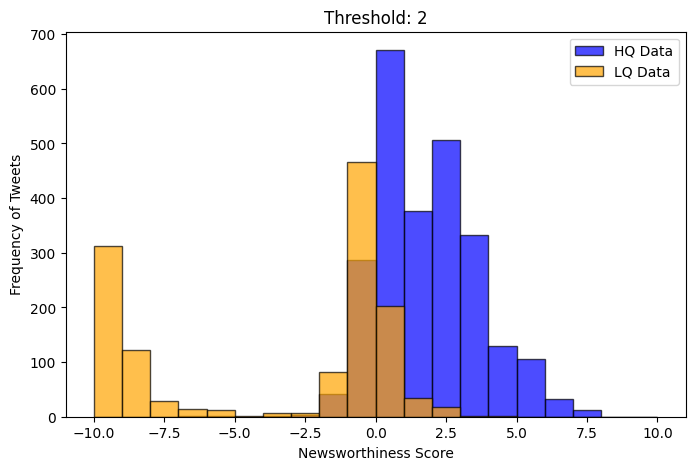

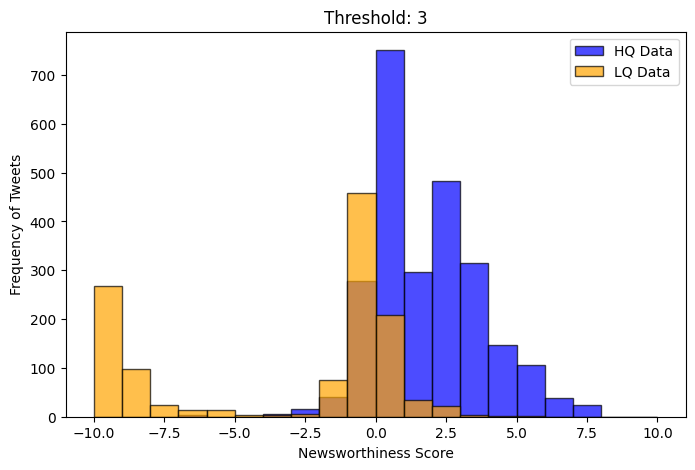

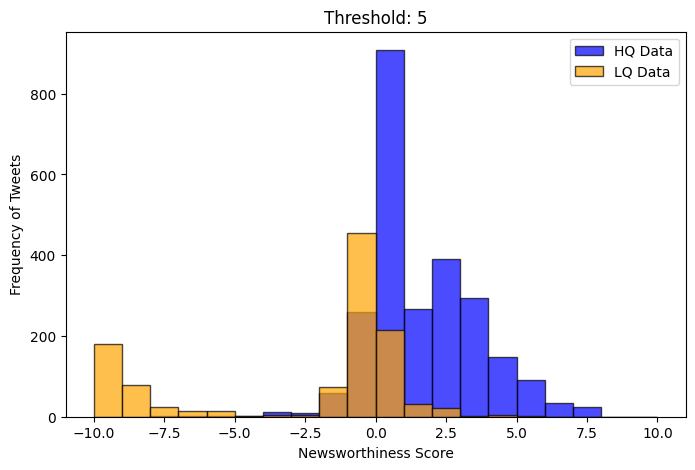

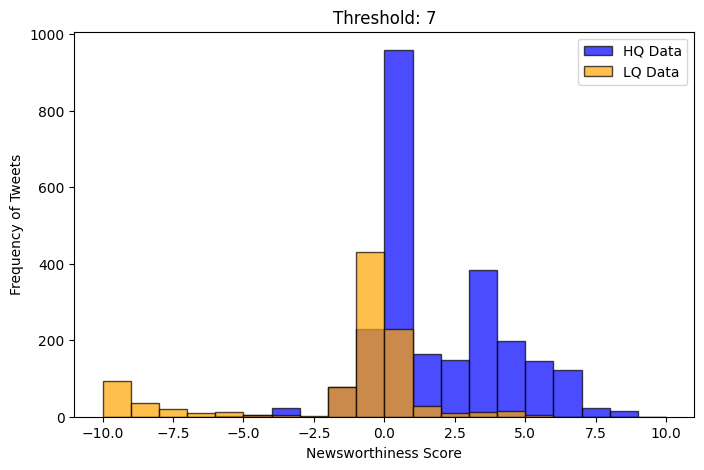

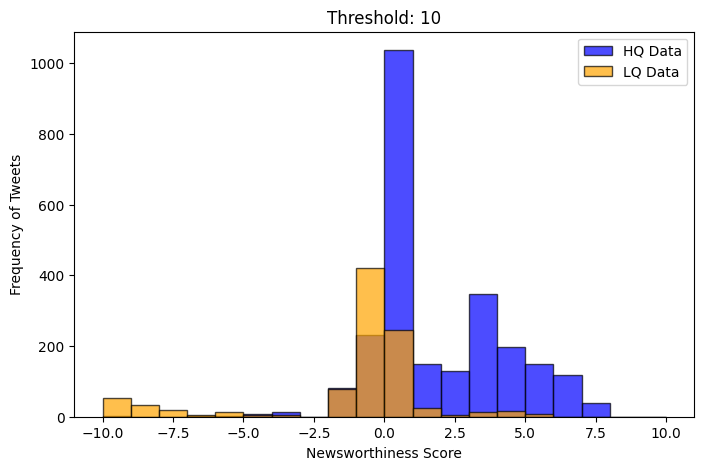

In [19]:
thresholds = [2, 3, 5, 7, 10]

# Iterate through each threshold
for i, thresh in enumerate(thresholds):
    HQdata_nScores = []
    LQdata_nScores = []

    # Calculate newsworthiness scores for HQ data
    for tweet in tqdm(HQdata, desc=f"Threshold: {thresh}", leave=False):
        Shqt = Slqt = 0
        for term in tweet['terms']:
            Rhqt = computeRhqt(term)
            Rlqt = computeRlqt(term)
            Shqt += Rhqt if Rhqt > thresh else 0
            Slqt += Rlqt if Rlqt > thresh else 0
        HQdata_nScores.append(math.log2((1 + Shqt) / (1 + Slqt)))

    # Calculate newsworthiness scores for LQ data
    for tweet in tqdm(LQdata, desc=f"Threshold: {thresh}", leave=False):
        Shqt = Slqt = 0
        for term in tweet['terms']:
            Rhqt = computeRhqt(term)
            Rlqt = computeRlqt(term)
            Shqt += Rhqt if Rhqt > thresh else 0
            Slqt += Rlqt if Rlqt > thresh else 0
        LQdata_nScores.append(math.log2((1 + Shqt) / (1 + Slqt)))

    # Create a single subplot for both HQ and LQ data
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot histogram for HQ data
    ax.hist(HQdata_nScores, bins=np.arange(-10, 11, 1), edgecolor='black', alpha=0.7, label='HQ Data', color='blue')

    # Plot histogram for LQ data
    ax.hist(LQdata_nScores, bins=np.arange(-10, 11, 1), edgecolor='black', alpha=0.7, label='LQ Data', color='orange')

    # Set plot title and labels
    ax.set_title(f"Threshold: {thresh}")
    ax.set_xlabel("Newsworthiness Score")
    ax.set_ylabel("Frequency of Tweets")
    ax.legend()

    # Show the plot
    plt.show()


In [20]:
# Calculate newsworthiness scores for HQ data with the chosen threshold
thresh = 5
HQdata_nScores = []
for tweet in tqdm(HQdata):
    Shqt = Slqt = 0
    for term in tweet['terms']:
        Rhqt = computeRhqt(term)
        Rlqt = computeRlqt(term)
        Shqt += Rhqt if Rhqt > thresh else 0
        Slqt += Rlqt if Rlqt > thresh else 0
    HQdata_nScores.append(math.log2((1+Shqt) / (1+Slqt)))

# Calculate newsworthiness scores for LQ data with the chosen threshold
LQdata_nScores = []
for tweet in tqdm(LQdata):
    Shqt = Slqt = 0
    for term in tweet['terms']:
        Rhqt = computeRhqt(term)
        Rlqt = computeRlqt(term)
        Shqt += Rhqt if Rhqt > thresh else 0
        Slqt += Rlqt if Rlqt > thresh else 0
    LQdata_nScores.append(math.log2((1+Shqt) / (1+Slqt)))

100%|███████████████████████████████████████████████████████████████████████████| 1527/1527 [00:00<00:00, 65657.60it/s]


Text(0, 0.5, 'Frequency of Tweets')

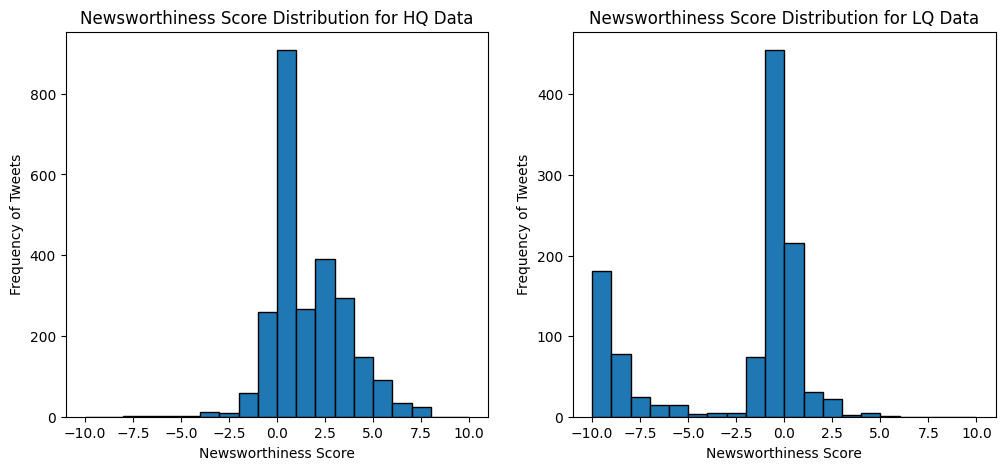

In [21]:
# Plotting the newsworthiness score distribution for HQ and LQ data
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(12, 5))

axs[0].hist(HQdata_nScores, bins=np.arange(-10, 11, 1), edgecolor='black')
axs[0].set_title("Newsworthiness Score Distribution for HQ Data")
axs[0].set_xlabel("Newsworthiness Score")
axs[0].set_ylabel("Frequency of Tweets")

axs[1].hist(LQdata_nScores, bins=np.arange(-10, 11, 1), edgecolor='black')
axs[1].set_title("Newsworthiness Score Distribution for LQ Data")
axs[1].set_xlabel("Newsworthiness Score")
axs[1].set_ylabel("Frequency of Tweets")

In [22]:
# Moving the data into a dataframe for further analysis
pd.set_option('display.max_colwidth', None)

hqlist = [item['text'] for item in HQdata]
lqlist = [item['text'] for item in LQdata]
combined_list = hqlist + lqlist
combined_scores = HQdata_nScores + LQdata_nScores
df = pd.DataFrame({
    'nScores': combined_scores,
    'text': combined_list
})
df.describe()

# filtered_df = df[(df['nScores'] > 0)]
# filtered_df = filtered_df.sort_values(by='nScores')
# filtered_df[filtered_df['nScores'] > 3.03].describe()

nScores
count  4028.000000
mean     -0.745631
std       4.483405
min     -10.823897
25%      -0.480199
50%       0.162661
75%       2.017892
max       7.911248

In [23]:
# Calculating Term Frequency for the High Quality Model with stop words
HQterms = []
for tweet in tqdm(HQdata):
    terms_local = text_pipeline_spacy_special(tweet['text'], True)
    HQterms += terms_local
    tweet['terms_sw'] = terms_local

hqTF = dict(Counter(HQterms))

# Calculating Term Frequency for the Low Quality Model with stop words
LQterms = []
for tweet in tqdm(LQdata):
    terms_local = text_pipeline_spacy_special(tweet['text'], True)
    LQterms += terms_local
    tweet['terms_sw'] = terms_local

lqTF = dict(Counter(LQterms))

Fbg = sum(bgTF.values())
Fhq = sum(hqTF.values())
Flq = sum(lqTF.values())

print("Total frequency F of HQ: {}, LQ: {}, BG: {}".format(Fhq, Flq, Fbg))

HQdata_nScores_sw = []
for tweet in tqdm(HQdata):
    Shqt = Slqt = 0
    for term in tweet['terms_sw']:
        Rhqt = computeRhqt(term)
        Rlqt = computeRlqt(term)
        Shqt += Rhqt if Rhqt > 5 else 0
        Slqt += Rlqt if Rlqt > 5 else 0
    HQdata_nScores_sw.append(math.log2((1+Shqt) / (1+Slqt)))

LQdata_nScores_sw = []
for tweet in tqdm(LQdata):
    Shqt = Slqt = 0
    for term in tweet['terms_sw']:
        Rhqt = computeRhqt(term)
        Rlqt = computeRlqt(term)
        Shqt += Rhqt if Rhqt > 5 else 0
        Slqt += Rlqt if Rlqt > 5 else 0
    LQdata_nScores_sw.append(math.log2((1+Shqt) / (1+Slqt)))

100%|█████████████████████████████████████████████████████████████████████████████| 1527/1527 [00:04<00:00, 362.20it/s]


Total frequency F of HQ: 39071, LQ: 32508, BG: 28392


100%|███████████████████████████████████████████████████████████████████████████| 1527/1527 [00:00<00:00, 79311.27it/s]


In [24]:
# Dataframe for the newsworthiness scores with stop words
combined_scores_sw = HQdata_nScores_sw + LQdata_nScores_sw
df_sw = pd.DataFrame({
    'nScores': combined_scores_sw,
    'text': combined_list
})
df_sw.describe()

nScores
count  4028.000000
mean     -0.099567
std       1.436357
min      -4.906881
25%      -0.313840
50%      -0.057999
75%       0.413774
max       6.992573

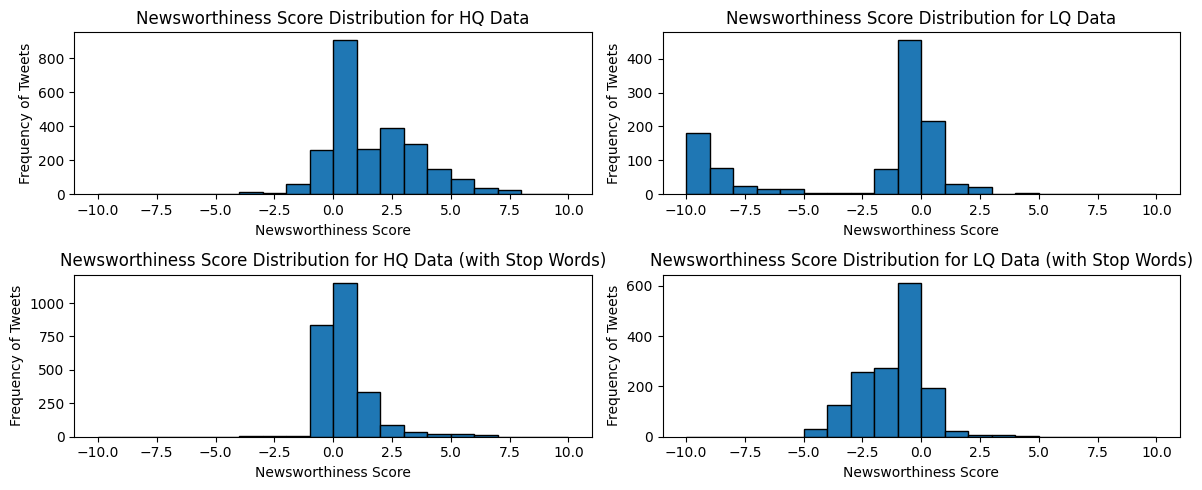

In [25]:
# Plotting the newsworthiness score distribution for HQ and LQ data with stop words compared to the score distribution without stop words
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(12, 5))

axs[0, 0].hist(HQdata_nScores, bins=np.arange(-10, 11, 1), edgecolor='black')
axs[0, 0].set_title("Newsworthiness Score Distribution for HQ Data")
axs[0, 0].set_xlabel("Newsworthiness Score")
axs[0, 0].set_ylabel("Frequency of Tweets")

axs[0, 1].hist(LQdata_nScores, bins=np.arange(-10, 11, 1), edgecolor='black')
axs[0, 1].set_title("Newsworthiness Score Distribution for LQ Data")
axs[0, 1].set_xlabel("Newsworthiness Score")
axs[0, 1].set_ylabel("Frequency of Tweets")

axs[1, 0].hist(HQdata_nScores_sw, bins=np.arange(-10, 11, 1), edgecolor='black')
axs[1, 0].set_title("Newsworthiness Score Distribution for HQ Data (with Stop Words)")
axs[1, 0].set_xlabel("Newsworthiness Score")
axs[1, 0].set_ylabel("Frequency of Tweets")

axs[1, 1].hist(LQdata_nScores_sw, bins=np.arange(-10, 11, 1), edgecolor='black')
axs[1, 1].set_title("Newsworthiness Score Distribution for LQ Data (with Stop Words)")
axs[1, 1].set_xlabel("Newsworthiness Score")
axs[1, 1].set_ylabel("Frequency of Tweets")

plt.tight_layout()

plt.show()


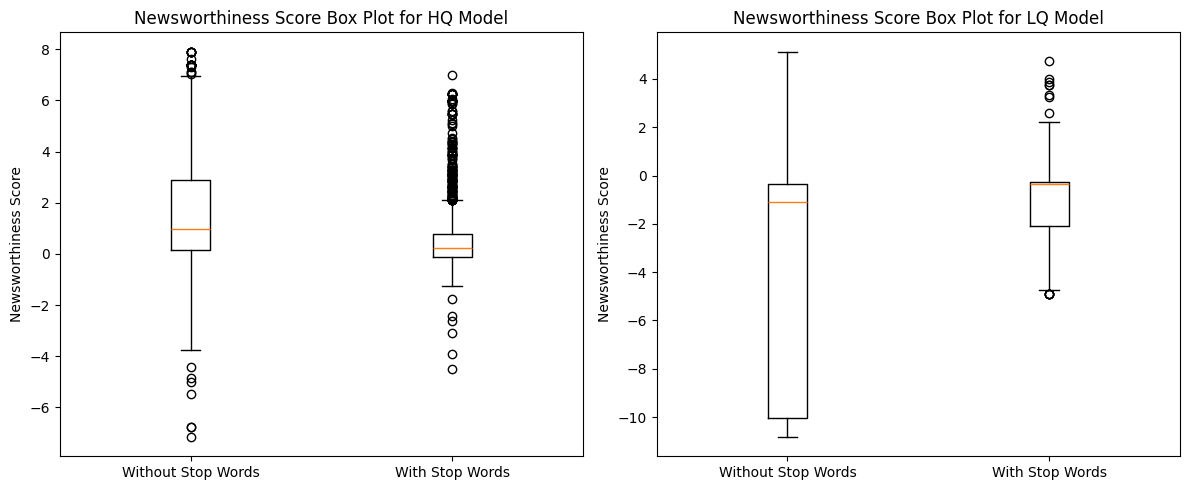

In [26]:
# Plotting the box plot for the newsworthiness scores with and without stop words
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(12, 5))

axs[0].boxplot([HQdata_nScores, HQdata_nScores_sw], labels=['Without Stop Words', 'With Stop Words'])
axs[0].set_title("Newsworthiness Score Box Plot for HQ Model")
axs[0].set_ylabel("Newsworthiness Score")

axs[1].boxplot([LQdata_nScores, LQdata_nScores_sw], labels=['Without Stop Words', 'With Stop Words'])
axs[1].set_title("Newsworthiness Score Box Plot for LQ Model")
axs[1].set_ylabel("Newsworthiness Score")

plt.tight_layout()
plt.show()


# Coursework 3: Combining newsworthiness and geolocalization

In [27]:
# Calculating Term Frequency for the Geo-localization tweets
geoTerms = []
for tweet in tqdm(final_data):
    terms_local = text_pipeline_spacy_special(tweet['text'])
    geoTerms += terms_local
    tweet['terms'] = terms_local

geoTF = dict(Counter(geoTerms))

100%|███████████████████████████████████████████████████████████████████████████| 13192/13192 [00:30<00:00, 429.20it/s]


In [28]:
# Calculating total frequency of the terms in the geo-localization tweets
Fgeo = sum(geoTF.values())

print("Total frequency F of HQ: {}, LQ: {}, BG: {}, geo: {}".format(Fhq, Flq, Fbg, Fgeo))

Total frequency F of HQ: 39071, LQ: 32508, BG: 28392, geo: 122555


In [29]:
# Calculating newsworthiness scores for the geo-localization tweets
geoData_nScores = []

for tweet in tqdm(final_data):
    Shqt = Slqt = 0
    for term in tweet['terms']:
        Rhqt = computeRhqt(term)
        Rlqt = computeRlqt(term)
        Shqt += Rhqt if Rhqt > 2 else 0
        Slqt += Rlqt if Rlqt > 2 else 0

    nScore = math.log2((1+Shqt) / (1+Slqt))
    geoData_nScores.append(nScore)
    tweet['nScore'] = nScore

100%|█████████████████████████████████████████████████████████████████████████| 13192/13192 [00:00<00:00, 99799.18it/s]


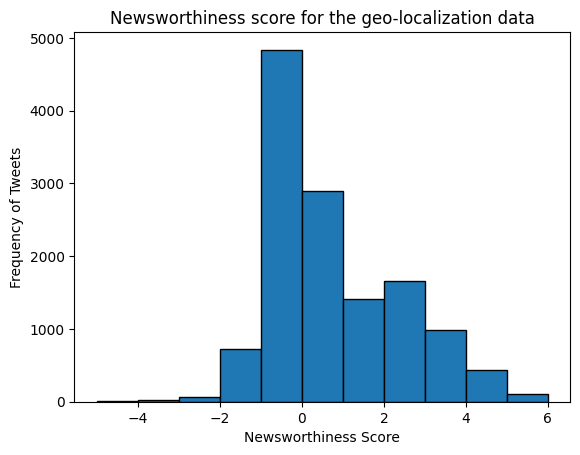

In [30]:
# Plotting the newsworthiness score distribution for the geo-localization tweets
plt.hist(geoData_nScores, bins=np.arange(-5, 7, 1), edgecolor='black')
plt.title('Newsworthiness score for the geo-localization data')
plt.xlabel('Newsworthiness Score')
plt.ylabel('Frequency of Tweets')

plt.show()

In [31]:
# Populating the grid data with the newsworthiness scores and tweet coordinates
locations = np.zeros([grid_creator.rows, grid_creator.columns])

pd_id = []
pd_row = []
pd_col = []
pd_text = []
pd_nscore = []

for tweet in tqdm(final_data, desc = "Processing Tweets", unit = "tweets"):
    tweet_id = tweet['_id']
    tweet_lon = tweet['coordinates'][0]
    tweet_lat = tweet['coordinates'][1]
    
    np_lat = np.empty([grid_creator.rows])
    np_lon = np.empty([grid_creator.columns])

    lat_index = 0
    lon_index = 0

    for i in range(len(rowPoints)):
        if rowPoints[i] >= tweet_lat:
            lat_index = i-1
            break
    for i in range(len(colPoints)):
        if colPoints[i] >= tweet_lon:
            lon_index = i-1
            break

    locations[lat_index, lon_index] += 1
    pd_id.append(tweet_id)
    pd_row.append(lat_index)
    pd_col.append(lon_index)
    pd_text.append(tweet['text'])
    pd_nscore.append(tweet['nScore'])
            

Processing Tweets: 100%|█████████████████████████████████████████████████| 13192/13192 [00:00<00:00, 146244.35tweets/s]


In [32]:
# Creating a dataframe for the grid data
loc_df = pd.DataFrame({
    'id': pd_id,
    'row': pd_row,
    'col': pd_col,
    'text': pd_text,
    'nscore': pd_nscore
})

In [33]:
# Printing the statistics of the grid data along with the tweet text
filtered_df = loc_df[['nscore', 'row', 'col', 'text']]
filtered_df.sort_values(by='nscore')

nscore  row  col  \
1286  -7.039124   34   26   
8733  -5.738852   37   22   
1039  -5.641244   37   22   
759   -4.686271   37   22   
979   -4.686271   37   22   
...         ...  ...  ...   
12257  6.410223   32   28   
12274  6.410223   32   28   
12276  6.410223   32   28   
243    6.713075   15   26   
1669   7.639397   33   27   

                                                                                                                                                                                                                                                       text  
1286                                                                                                                                                              Errol Spence is going to attack Crawford’s body says Al Bernstein https://t.co/OKxjEgDDz3  
8733                                                                                                                                                               My son played cricket at Lord’s #retires @ Lord's Cricket Ground https://t.co/QayjzinoXQ  
1039                                                                                                                               29. Family trip minus @francis_bradley to the hundred finals at Lords….. @ Lord's Cricket Ground https://t.co/0kZUDRdqdk  
759                                                                                                                                                                                    #cricket #TheHundred @ Lord's Cricket Ground https://t.co/pFOyx0bxqi  
979                                                                                                                                                                                                         @ Lord's Cricket Ground https://t.co/M3OPqRosRR  
...                                                                                                                                                                                                                                                     ...  
12257                                                                                                               Lots of fun and #friendship at Key Stage One today, playing and enjoying the glorious Autumn  sun  @ Bermondsey https://t.co/DfbjZy4QIo  
12274                                                                                                               Lots of fun and #friendship at Key Stage One today, playing and enjoying the glorious Autumn  sun  @ Bermondsey https://t.co/wiJZyafUOI  
12276                                                                                                               Lots of fun and #friendship at Key Stage One today, playing and enjoying the glorious Autumn  sun  @ Bermondsey https://t.co/LV6IAMT7GM  
243                                                                                                                          Can you recommend anyone for this job? Barista - Store# 12515, CROYDON-CENTRALE SCH - https://t.co/KUCCOACkmy #Retail #Croydon  
1669   sundayyyy 🧋\n\n__________\n\nCoffee moment | minimal aesthetic | Parisian style | neutrals moodboard | aesthetics | paris | explore page | beige aesthetic | neutral style | selfcare | coffee lover | iced latte | selfcare https://t.co/iEQWzCxBk3  

[13192 rows x 4 columns]

In [34]:
# Printing the statistics of the grid data along with the tweet text for the filtered threshold
filtered_df[filtered_df['nscore'] > 0.758].sort_values(by='nscore').head()

nscore  row  col  \
11200  0.760925   35   26   
10235  0.760925   33   25   
1695   0.762326   21   24   
7514   0.763401   15   25   
7036   0.763401   15   25   

                                                                                                                                                                                                                                                              text  
11200                                                                                                                                                                   All taken within a radius of 100 metres @ Barbican, City Of London https://t.co/zf3TDMtd7s  
10235                                                                                                                                                                                             I'm at Thames Rockets in London, England https://t.co/omSl0mysdk  
1695   Team De Ver @team_de_ver London to Whitstable Club Ride. \n#teamdever \n#teamdevercc \n#clubride\n#cycling \n#cyclinglifestyle \n#cyclinglife\n#roadbike\n#london \n#whitsable \n#londontowhitstable \n#keepriding \n#enjoyyourride https://t.co/AAVi9bkybZ  
7514                                                                                                                                                                              On my way to watch @cpfc women @ Croydon, United Kingdom https://t.co/6ZYUC6voUC  
7036                                                                                                                                                               Jessie's nicked one of Mum's Tuna rice cakes  @ Croydon, United Kingdom https://t.co/ZQkxCS4NRH

In [35]:
# Visualizing the grid data with the newsworthiness scores for a given threshold along with statistics of the data present
def visualize_grid(df, nscore_threshold):
    
    grids = np.zeros((59, 48))
    rows, cols = len(rowPoints), len(colPoints)

    filter_df = df[df['nscore'] >= nscore_threshold]

    
    for index, row in filter_df.iterrows():
        row_index = int(row['row'])
        col_index = int(row['col'])
        grids[row_index, col_index] += 1


    print_geo_statistics(pd.DataFrame(grids))
    print("=======================================")
    print("Printing random samples from the filtered dataframe for emperical analysis")
    print(filter_df.sample(10)['text'].to_string(index=False))

    map_image = plt.imread('london_city.png')
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(map_image, extent=[0, cols, 0, rows])

    xticks = np.arange(0, cols, 3)
    yticks = np.arange(0, rows, 3)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticks(np.arange(0, cols, 1), minor=True)
    ax.set_yticks(np.arange(rows-1, -1, -1), minor=True)
    ax.grid(which='both', color='black', linestyle='--', linewidth=0.2)

    
    plt.imshow(grids, cmap='gist_heat_r', norm=LogNorm(), alpha=0.8, origin='lower', aspect='auto', extent=[0, 48, 0, 59])
    plt.colorbar(label='Nscore > {}'.format(nscore_threshold))
    plt.title('Grid Visualization with nScores >= {}'.format(nscore_threshold))
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

Total tweets across the entire geo grid: 5040
The highest number of tweets in the grid is 711.0 with coordinates of 51.50606786440678, -0.14132
The density of non zero values in the grid is: 0.06002824858757062
Printing top 5 cells with highest number of tweets with coordinates: 
0: Total number of tweets: 711 with coordinates in 51.50606786440678, -0.14132
1: Total number of tweets: 408 with coordinates in 51.51326638983051, -0.12374999999999997
2: Total number of tweets: 235 with coordinates in 51.49886933898305, -0.14132
3: Total number of tweets: 209 with coordinates in 51.51326638983051, -0.14132
4: Total number of tweets: 155 with coordinates in 51.49886933898305, -0.15888999999999998
The average number of tweet per grid including inculding zero values: 1.7796610169491525
The average number of tweet per grid with non zero values: 27.43203463203463
Standard Deviation of number of tweets across all the non zero grids: 71.40561791207189
Printing random samples from the filtered data

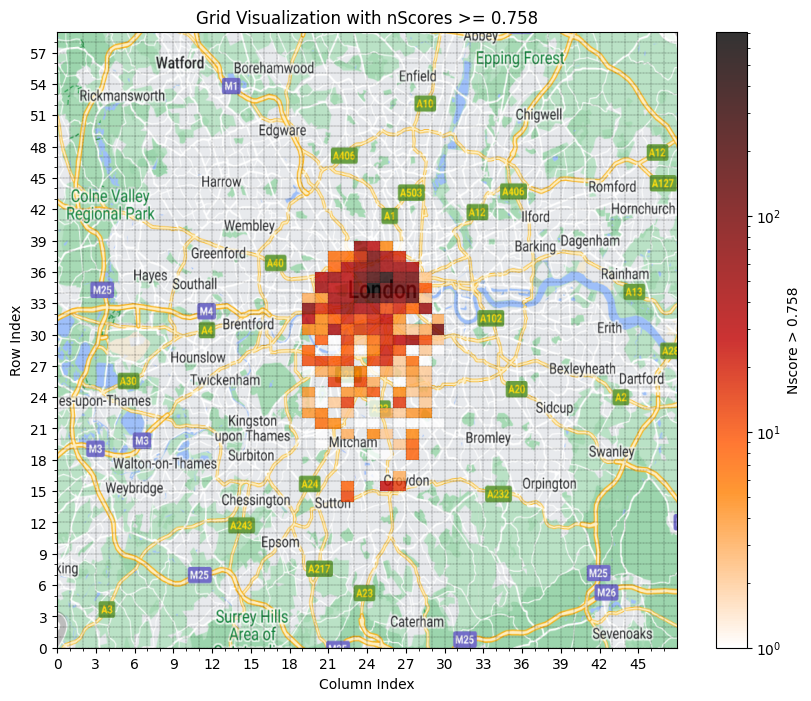

Total tweets across the entire geo grid: 4630
The highest number of tweets in the grid is 662.0 with coordinates of 51.50606786440678, -0.14132
The density of non zero values in the grid is: 0.05861581920903955
Printing top 5 cells with highest number of tweets with coordinates: 
0: Total number of tweets: 662 with coordinates in 51.50606786440678, -0.14132
1: Total number of tweets: 315 with coordinates in 51.51326638983051, -0.12374999999999997
2: Total number of tweets: 212 with coordinates in 51.49886933898305, -0.14132
3: Total number of tweets: 189 with coordinates in 51.51326638983051, -0.14132
4: Total number of tweets: 152 with coordinates in 51.49886933898305, -0.15888999999999998
The average number of tweet per grid including inculding zero values: 1.6348870056497173
The average number of tweet per grid with non zero values: 26.15169475777061
Standard Deviation of number of tweets across all the non zero grids: 65.1076520286476
Printing random samples from the filtered dataf

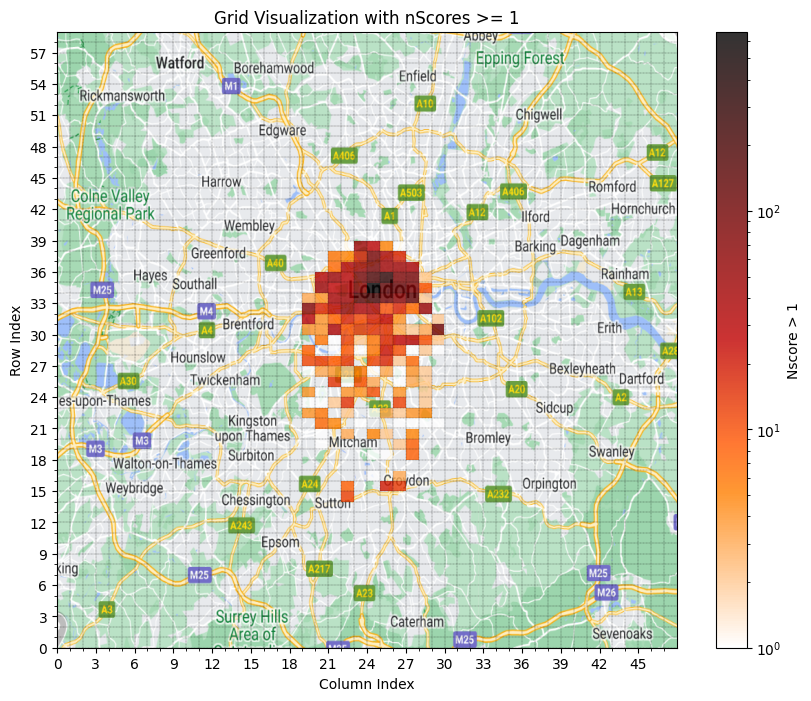

Total tweets across the entire geo grid: 3219
The highest number of tweets in the grid is 468.0 with coordinates of 51.50606786440678, -0.14132
The density of non zero values in the grid is: 0.05296610169491525
Printing top 5 cells with highest number of tweets with coordinates: 
0: Total number of tweets: 468 with coordinates in 51.50606786440678, -0.14132
1: Total number of tweets: 148 with coordinates in 51.51326638983051, -0.14132
2: Total number of tweets: 123 with coordinates in 51.49886933898305, -0.15888999999999998
3: Total number of tweets: 109 with coordinates in 51.51326638983051, -0.12374999999999997
4: Total number of tweets: 105 with coordinates in 51.49886933898305, -0.14132
The average number of tweet per grid including inculding zero values: 1.1366525423728813
The average number of tweet per grid with non zero values: 20.5354797979798
Standard Deviation of number of tweets across all the non zero grids: 45.54953495073455
Printing random samples from the filtered dataf

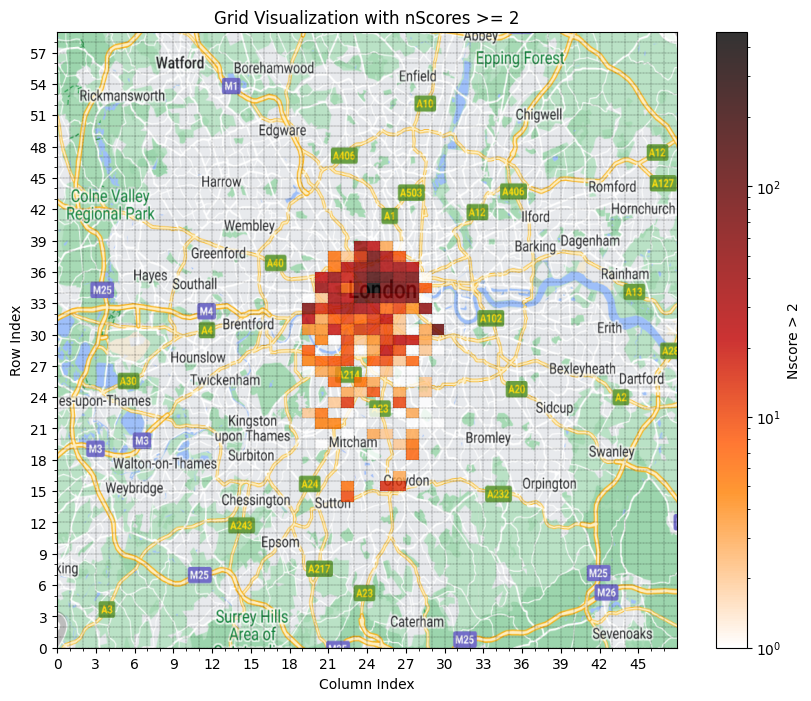

Total tweets across the entire geo grid: 573
The highest number of tweets in the grid is 64.0 with coordinates of 51.50606786440678, -0.14132
The density of non zero values in the grid is: 0.033192090395480225
Printing top 5 cells with highest number of tweets with coordinates: 
0: Total number of tweets: 64 with coordinates in 51.50606786440678, -0.14132
1: Total number of tweets: 32 with coordinates in 51.51326638983051, -0.14132
2: Total number of tweets: 30 with coordinates in 51.49886933898305, -0.15888999999999998
3: Total number of tweets: 27 with coordinates in 51.491670813559324, -0.07103999999999999
4: Total number of tweets: 19 with coordinates in 51.52046491525424, -0.10618
The average number of tweet per grid including inculding zero values: 0.20233050847457626
The average number of tweet per grid with non zero values: 7.143267843267844
Standard Deviation of number of tweets across all the non zero grids: 8.597410398981765
Printing random samples from the filtered datafram

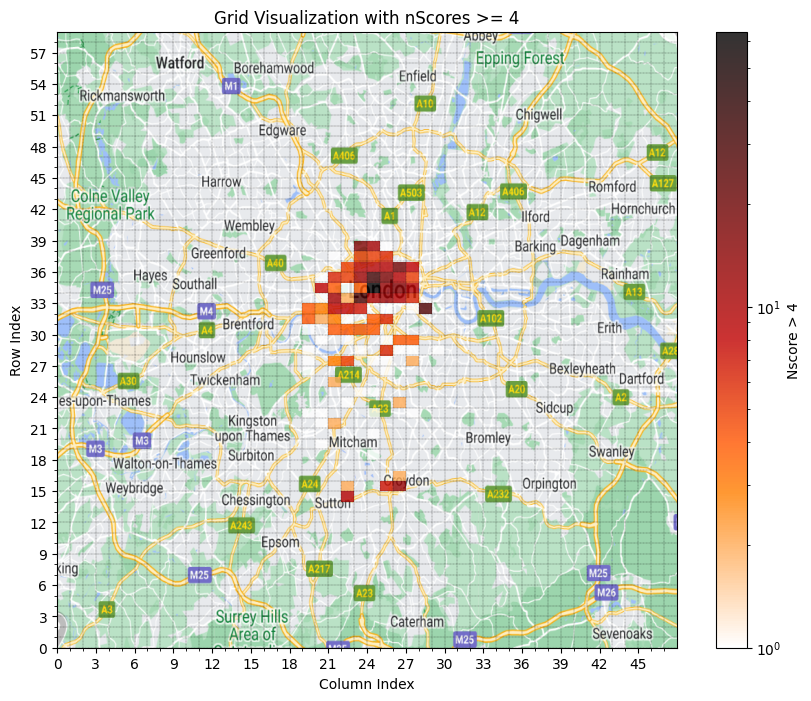

Total tweets across the entire geo grid: 33
The highest number of tweets in the grid is 24.0 with coordinates of 51.491670813559324, -0.07103999999999999
The density of non zero values in the grid is: 0.0035310734463276836
Printing top 5 cells with highest number of tweets with coordinates: 
0: Total number of tweets: 24 with coordinates in 51.491670813559324, -0.07103999999999999
1: Total number of tweets: 1 with coordinates in 51.49886933898305, -0.19402999999999998
2: Total number of tweets: 1 with coordinates in 51.43408261016949, -0.14132
3: Total number of tweets: 1 with coordinates in 51.50606786440678, -0.10618
4: Total number of tweets: 1 with coordinates in 51.36929588135593, -0.12374999999999997
The average number of tweet per grid including inculding zero values: 0.011652542372881358
The average number of tweet per grid with non zero values: 4.285714285714286
Standard Deviation of number of tweets across all the non zero grids: 7.273238618387273
Printing random samples from

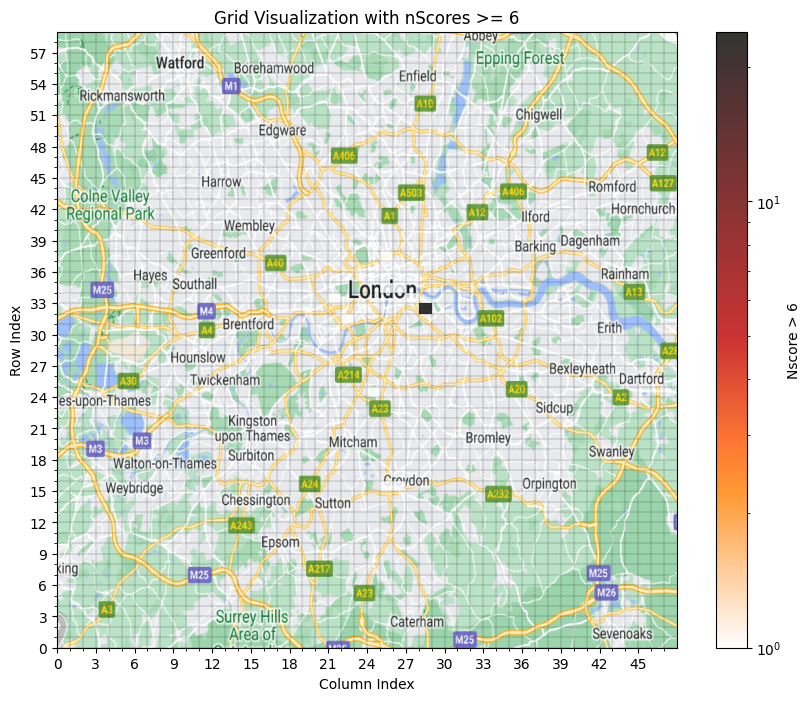

In [36]:
# Visualizing the grid data with the newsworthiness scores for a given threshold
visualize_grid(filtered_df, 0.758)
visualize_grid(filtered_df, 1)
visualize_grid(filtered_df, 2)
visualize_grid(filtered_df, 4)
visualize_grid(filtered_df, 6)